# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import pickle
import tensorflow as tf
from tensorflow.keras.layers import  LSTM, Dropout, Embedding, Dense, Bidirectional,Input
from tensorflow.keras.models import Sequential
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [4]:
data = pd.read_csv('Dataset/train.csv')

data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# Data visualization

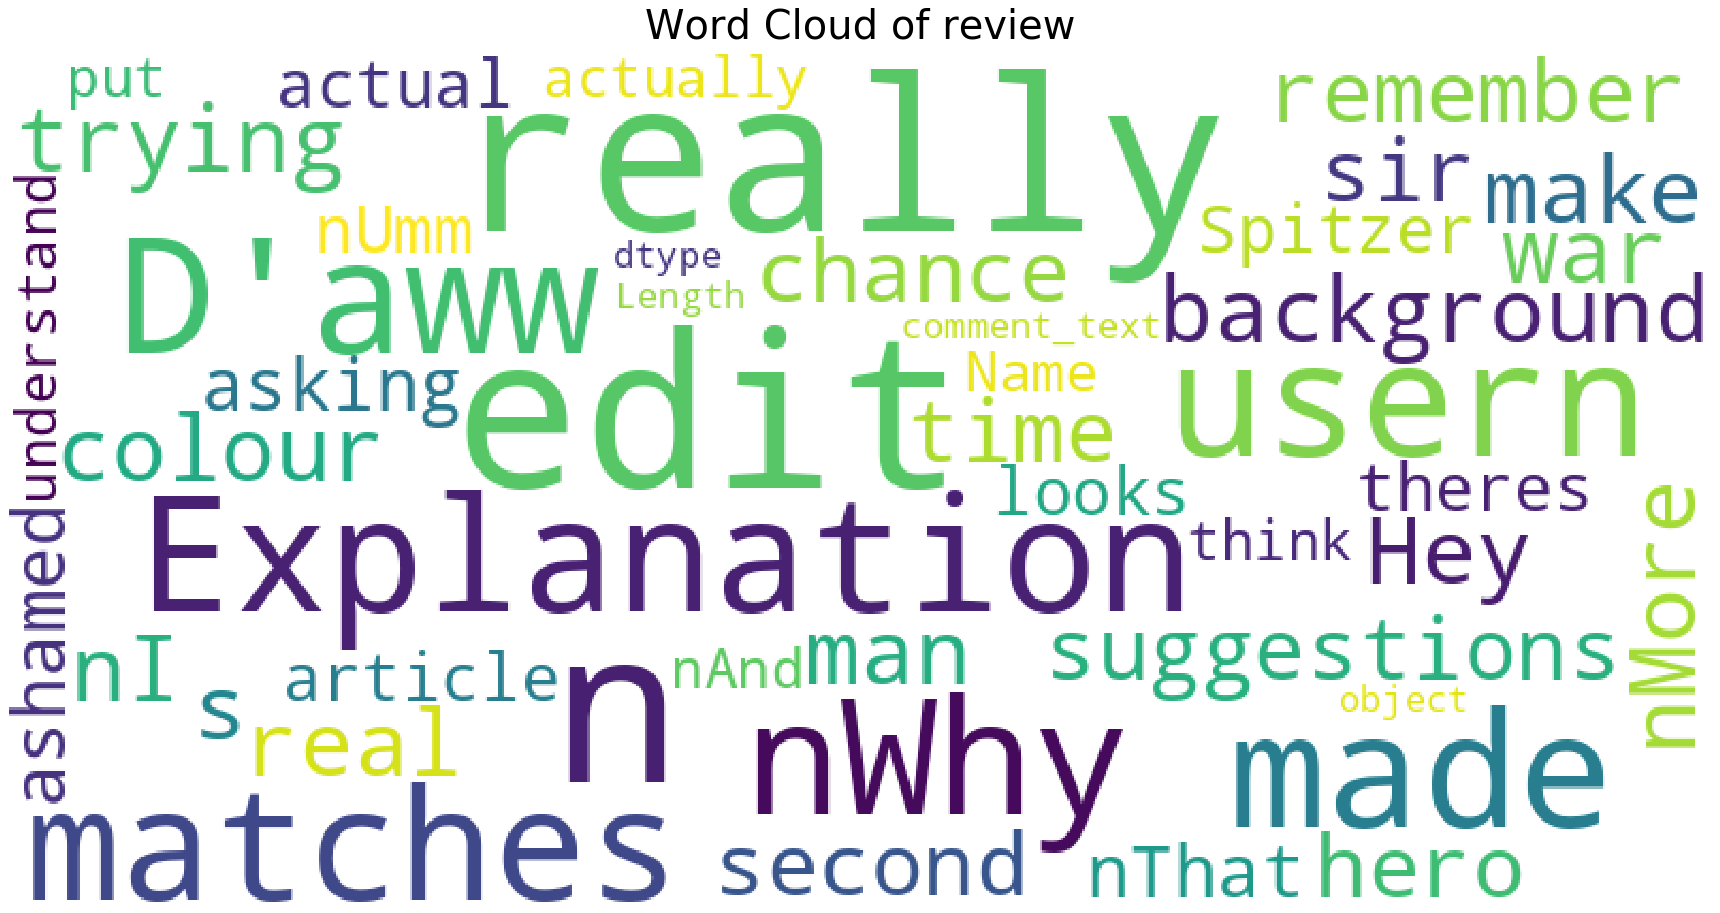

In [7]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(data["comment_text"], title="Word Cloud of review")

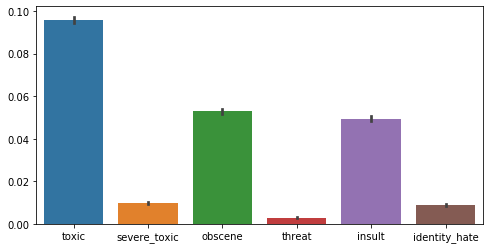

In [8]:
plt.figure(figsize=(8,4))
sns.barplot(data)
plt.show()

159571


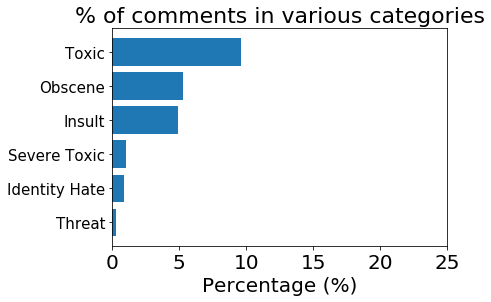

In [9]:
num_rows = len(data)
print(num_rows)
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100
ind = np.arange(6)
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()

In [10]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [11]:
data_tox = data.loc[:,['id','comment_text','toxic']]
data_tox['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [12]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]
data_thr = data.loc[:,['id','comment_text','threat']]

In [13]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

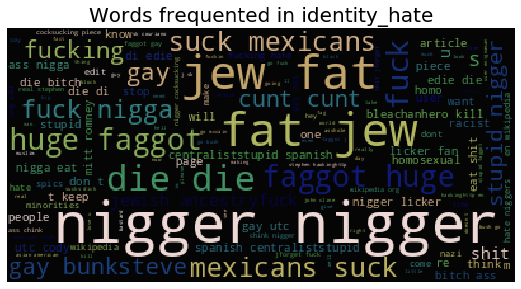

In [14]:
wordcloud(data_ide,'identity_hate')

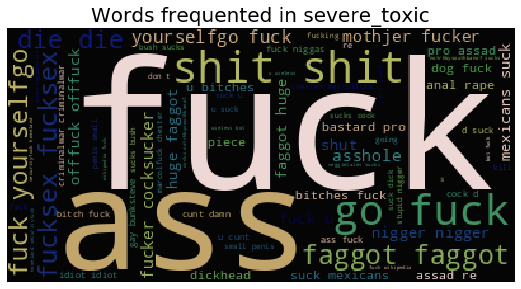

In [15]:
wordcloud(data_sev,'severe_toxic')

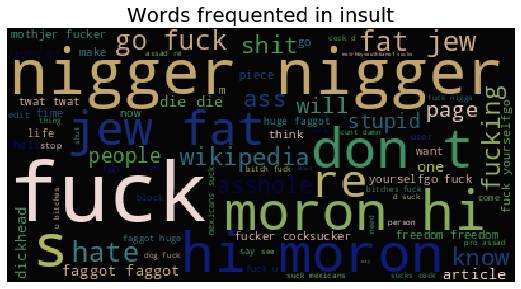

In [16]:
wordcloud(data_ins,'insult')

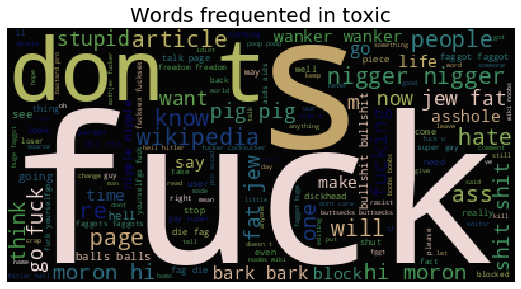

In [17]:
wordcloud(data_tox,'toxic')

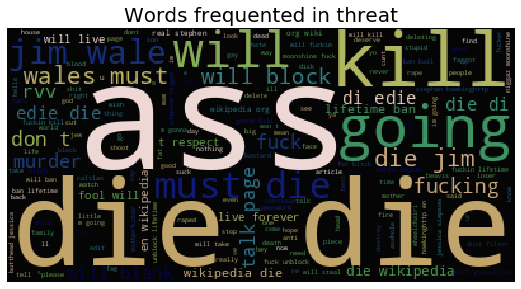

In [18]:
wordcloud(data_thr,'threat')

# Model Building

In [19]:
X = data['comment_text']
y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

y_train = y_train.astype(int)

In [22]:
pickle.dump(vectorizer,open('tk.pkl','wb'))

# KNN

In [23]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
predictions = KNN.predict(X_test)
val = (accuracy_score(y_test, predictions) * 100)

In [24]:
y_pred = KNN.predict(X_test)
a = accuracy_score(y_test, y_pred) 
p = precision_score(y_test,y_pred,average='macro') 
r = recall_score(y_test,y_pred,average='macro')
f = f1_score(y_test,y_pred,average='macro') 



print("Accuracy: {:.2f}%".format(a))
print("Precision: {:.2f}%".format(p))
print("Recall: {:.2f}%".format(r))
print("F1-score: {:.2f}%".format(f))

Accuracy: 0.89%
Precision: 0.57%
Recall: 0.28%
F1-score: 0.37%


# Xgboost

In [26]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
val = (accuracy_score(y_test, predictions) * 100)

In [27]:
y_pred = xgb.predict(X_test)
a1 = accuracy_score(y_test, y_pred) 
p1 = precision_score(y_test,y_pred,average='macro') 
r1 = recall_score(y_test,y_pred,average='macro')
f1 = f1_score(y_test,y_pred,average='macro') 



print("Accuracy: {:.2f}%".format(a1))
print("Precision: {:.2f}%".format(p1))
print("Recall: {:.2f}%".format(r1))
print("F1-score: {:.2f}%".format(f1))

Accuracy: 0.91%
Precision: 0.68%
Recall: 0.37%
F1-score: 0.47%


# ANN

In [28]:
ann = MLPClassifier(random_state=1, max_iter=300)
ann.fit(X_train, y_train)
predictions = ann.predict(X_test)
val = (accuracy_score(y_test, predictions) * 100)

In [29]:
y_pred = ann.predict(X_test)
a2 = accuracy_score(y_test, y_pred) 
p2 = precision_score(y_test,y_pred,average='macro') 
r2 = recall_score(y_test,y_pred,average='macro')
f2 = f1_score(y_test,y_pred,average='macro') 



print("Accuracy: {:.2f}%".format(a2))
print("Precision: {:.2f}%".format(p2))
print("Recall: {:.2f}%".format(r2))
print("F1-score: {:.2f}%".format(f2))

Accuracy: 0.88%
Precision: 0.51%
Recall: 0.44%
F1-score: 0.47%


# LSTM

In [30]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)
max_sequence_length = X_padded.shape[1]  
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], max_sequence_length, 1))
X_val_reshaped = np.reshape(X_val, (X_val.shape[0], max_sequence_length, 1))


model = Sequential()
model.add(LSTM(units=64, input_shape=(max_sequence_length, 1)))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=5, batch_size=32)

Epoch 1/5
3990/3990 [==============================] - 135s 33ms/step - loss: 0.1361 - accuracy: 0.9738 - val_loss: 0.1293 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - 132s 33ms/step - loss: 0.1250 - accuracy: 0.9918 - val_loss: 0.1249 - val_accuracy: 0.9941
Epoch 3/5
3990/3990 [==============================] - 135s 34ms/step - loss: 0.1236 - accuracy: 0.9942 - val_loss: 0.1239 - val_accuracy: 0.9941
Epoch 4/5
3990/3990 [==============================] - 133s 33ms/step - loss: 0.1225 - accuracy: 0.9942 - val_loss: 0.1230 - val_accuracy: 0.9941
Epoch 5/5
3990/3990 [==============================] - 134s 34ms/step - loss: 0.1212 - accuracy: 0.9942 - val_loss: 0.1228 - val_accuracy: 0.9941


In [32]:
y_pred_prob = model.predict(X_val_reshaped)

y_test = y_val
y_pred = (y_pred_prob > 0.5).astype(int)  

a3 = accuracy_score(y_test, y_pred)
p3 = precision_score(y_test, y_pred, average='macro')
r3 = recall_score(y_test, y_pred, average='macro')
f3 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", a3)
print("Precision:", p3)
print("Recall:", r3)
print("F1-score:", f3)

Accuracy: 0.894908350305499
Precision: 0.31808042996020097
Recall: 0.01924845282495871
F1-score: 0.03514074334303053


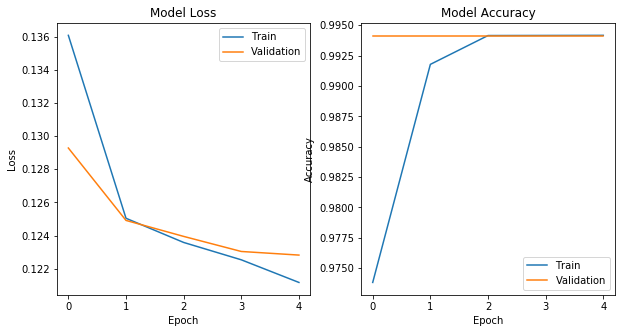

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [34]:
model.save('models/lstm.h5')

# BiLSTM

In [35]:
model = Sequential()
model.add(Bidirectional(LSTM(units=64), input_shape=(max_sequence_length, 1)))
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=5, batch_size=32)

Epoch 1/5
3990/3990 [==============================] - 264s 66ms/step - loss: 0.1344 - accuracy: 0.9845 - val_loss: 0.1263 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - 265s 66ms/step - loss: 0.1235 - accuracy: 0.9940 - val_loss: 0.1253 - val_accuracy: 0.9941
Epoch 3/5
3990/3990 [==============================] - 265s 66ms/step - loss: 0.1211 - accuracy: 0.9940 - val_loss: 0.1220 - val_accuracy: 0.9941
Epoch 4/5
3990/3990 [==============================] - 263s 66ms/step - loss: 0.1193 - accuracy: 0.9941 - val_loss: 0.1200 - val_accuracy: 0.9940
Epoch 5/5
3990/3990 [==============================] - 264s 66ms/step - loss: 0.1181 - accuracy: 0.9941 - val_loss: 0.1196 - val_accuracy: 0.9940


In [36]:
y_pred_prob = model.predict(X_val_reshaped)

y_test = y_val
y_pred = (y_pred_prob > 0.5).astype(int)  

a4 = accuracy_score(y_test, y_pred)
p4 = precision_score(y_test, y_pred, average='macro')
r4 = recall_score(y_test, y_pred, average='macro')
f4 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", a4)
print("Precision:", p4)
print("Recall:", r4)
print("F1-score:", f4)

Accuracy: 0.8976656744477518
Precision: 0.5074056990569906
Recall: 0.029392894607194478
F1-score: 0.05516143052812748


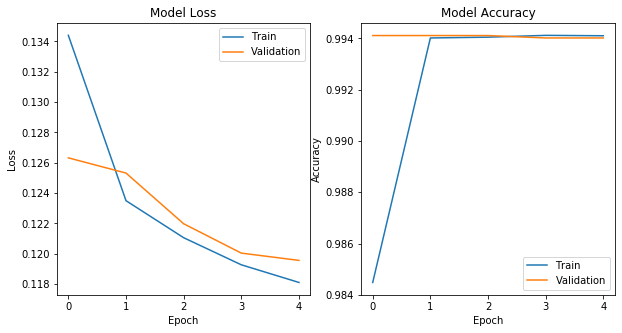

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [38]:
model.save('models/bilstm.h5')

# Comparison

In [39]:

results = {
    'Accuracy': [a, a1, a2, a3, a4],
    'Recall': [r, r1, r2, r3, r4],
    'Precision': [p, p1, p2, p3, p4],
    'F1': [f, f1, f2, f3, f4] }

index = ['KNN','Xgboost','ANN','LSTM','BiLSTM']

In [40]:
results =pd.DataFrame(results,index=index)
print(results)

         Accuracy    Recall  Precision        F1
KNN      0.890428  0.284419   0.570325  0.371451
Xgboost  0.913677  0.370479   0.684626  0.470356
ANN      0.884662  0.444133   0.511760  0.473257
LSTM     0.894908  0.019248   0.318080  0.035141
BiLSTM   0.897666  0.029393   0.507406  0.055161


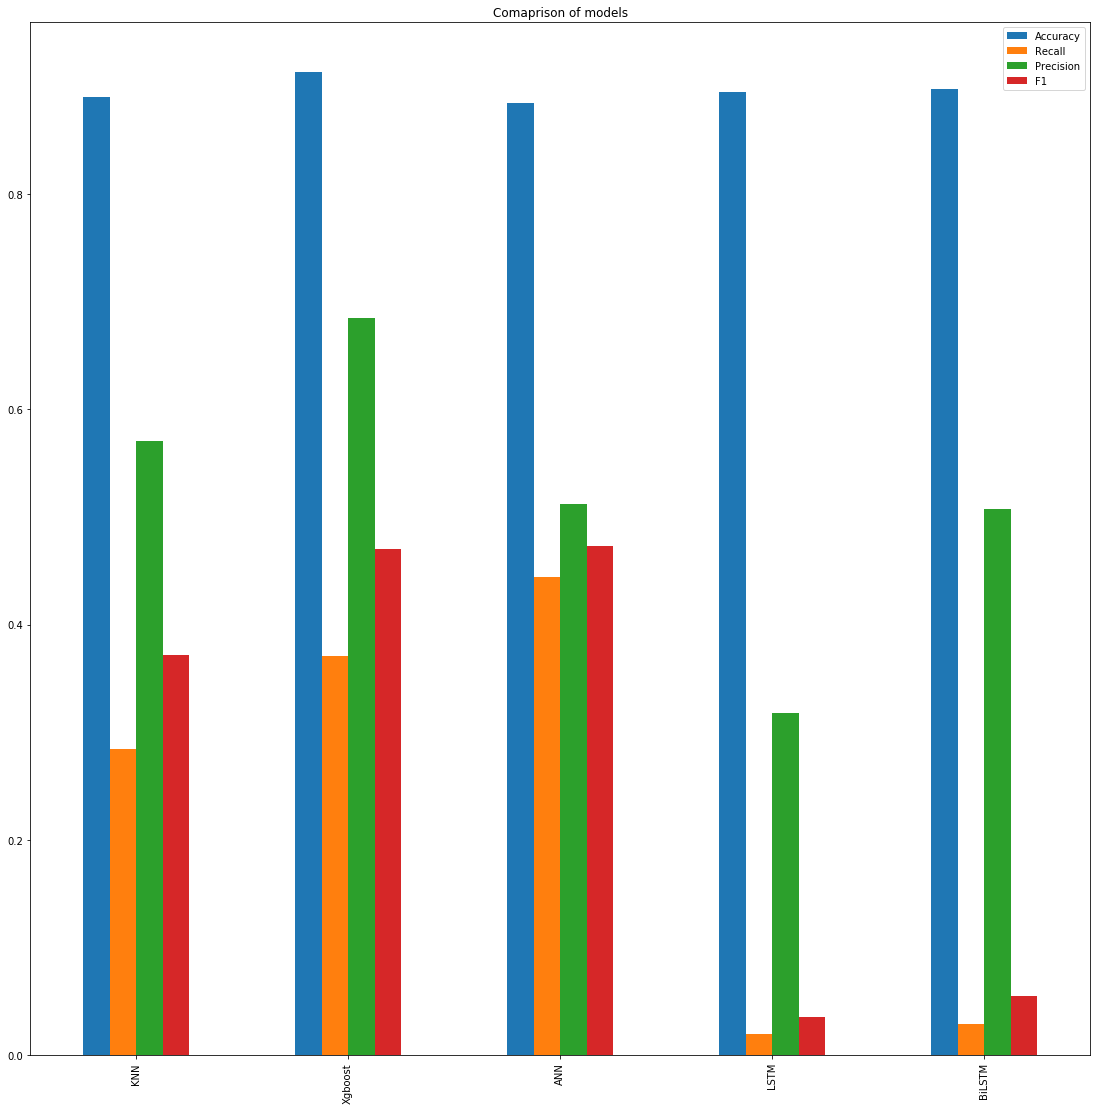

In [41]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

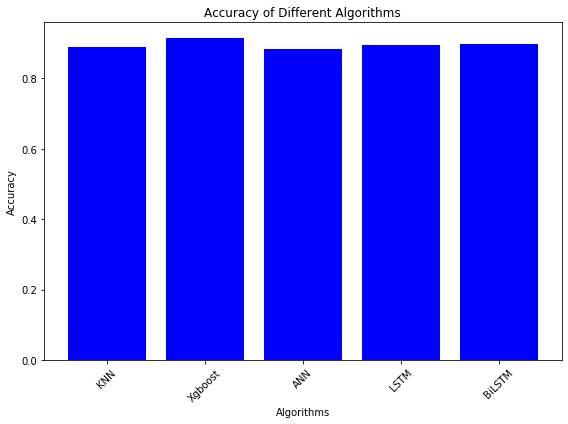

In [42]:
accuracy_values = results['Accuracy']
accuracy_df = pd.DataFrame({'Algorithms': index, 'Accuracy': accuracy_values})

plt.figure(figsize=(8, 6))
plt.bar(accuracy_df['Algorithms'], accuracy_df['Accuracy'], color='blue')
plt.title('Accuracy of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

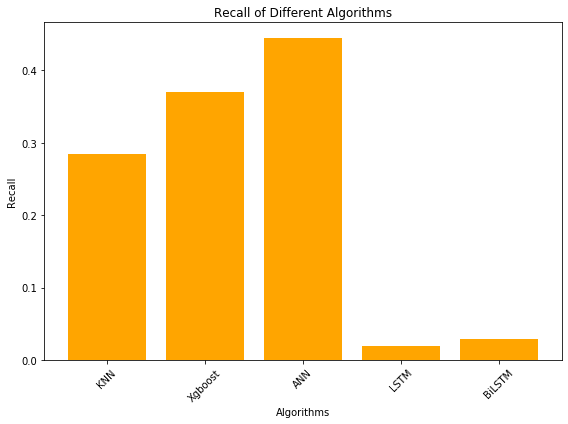

In [43]:
recall_values = results['Recall']
recall_df = pd.DataFrame({'Algorithms': index, 'Recall': recall_values})

plt.figure(figsize=(8, 6))
plt.bar(recall_df['Algorithms'], recall_df['Recall'], color='orange')
plt.title('Recall of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

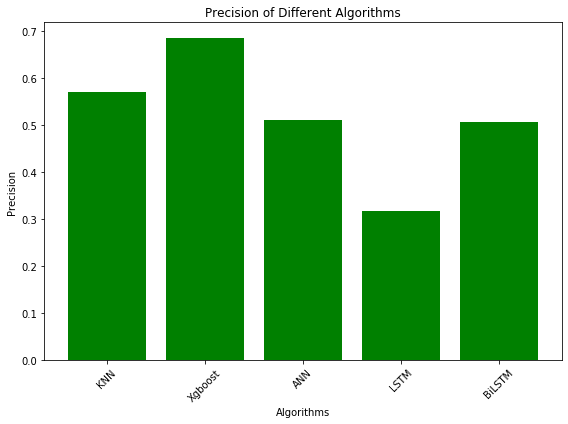

In [44]:
precision_values = results['Precision']
precision_df = pd.DataFrame({'Algorithms': index, 'Precision': precision_values})

plt.figure(figsize=(8, 6))
plt.bar(precision_df['Algorithms'], precision_df['Precision'], color='green')
plt.title('Precision of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

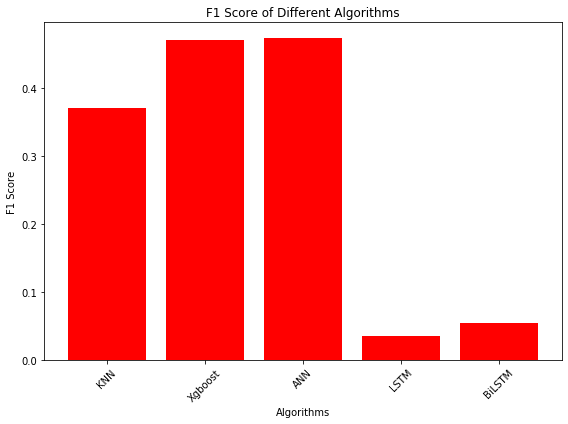

In [45]:
f1_values = results['F1']
f1_df = pd.DataFrame({'Algorithms': index, 'F1 Score': f1_values})

plt.figure(figsize=(8, 6))
plt.bar(f1_df['Algorithms'], f1_df['F1 Score'], color='red')
plt.title('F1 Score of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saving Model

In [46]:
pickle.dump(xgb,open('model.pkl','wb'))